In [17]:
# Installer les libraries
! pip install datasets rouge_score sacrebleu sacrebleu evaluate

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [3]:
import re
import nltk
from nltk.corpus import stopwords
import spacy
from datasets import DatasetDict,load_dataset
from sklearn.metrics.pairwise import cosine_similarity
import sacrebleu
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Trainer, TrainingArguments, BertTokenizer, BertModel
import os
import gc
import torch
import evaluate
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

2024-11-20 18:33:32.915158: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 1.1. Téléchargement du jeu de données CNN/Daily 

In [4]:
# Chargement des données
ds = load_dataset("abisee/cnn_dailymail", "3.0.0")
# Exploration des données
print(ds['train'].features)

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

{'article': Value(dtype='string', id=None), 'highlights': Value(dtype='string', id=None), 'id': Value(dtype='string', id=None)}


## 1.2. Préparation des données en suivant ces étapes :

### 1.2.1 Charger les textes et les résumés associés.

In [5]:
# Chargement des textes et résumés des cinq premiers articles
for i in range(5):
    article = ds['train'][i]['article']
    resumer = ds['train'][i]['highlights']
    print(f"Article {i+1}:\n", article)
    print(f"Résumé {i+1}:\n", resumer)
    print("="*150)

Article 1:
 LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won't cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don't plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month. "I don't think I'll be particularly extravagant. "The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs." At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film "Hostel: Part II," currently six places below his number one movie on the UK box office chart. De

### 1.2.2 Prétraitement des données

Etape 1 : Transformer en miniscules, suppression des caractères spéciaux, Supprimer les espaces supplementaires

In [6]:
# Fonction de nettoyage du texte
def preprocess_function(lambdas):
    cleaned_articles = []
    for article in lambdas['article']:
        article = article.lower()
        article = re.sub(r'[^a-zA-Z0-9\s]', '', article)
        article = re.sub(r'\s+', ' ', article).strip()
        cleaned_articles.append(article)

    cleaned_summaries = []
    for summary in lambdas['highlights']:
        summary = summary.lower()
        summary = re.sub(r'[^a-zA-Z0-9\s]', '', summary)
        summary = re.sub(r'\s+', ' ', summary).strip()
        cleaned_summaries.append(summary)
        
    return {'article': cleaned_articles, 'highlights': cleaned_summaries}

# Appliquons le prétraitement sur l'ensemble du jeu de données
ds_cleaned = ds.map(preprocess_function, batched=True)

# Visualisation d'un exemple après prétraitement
#print(ds_cleaned['train'][0])
article = ds_cleaned['train']['article'][0]
resumer = ds_cleaned['train']['highlights'][0]
print(f"Article :\n", article)
print(f"Résumé :\n", resumer)

Map:   0%|          | 0/287113 [00:00<?, ? examples/s]

Map:   0%|          | 0/13368 [00:00<?, ? examples/s]

Map:   0%|          | 0/11490 [00:00<?, ? examples/s]

Article :
 london england reuters harry potter star daniel radcliffe gains access to a reported 20 million 411 million fortune as he turns 18 on monday but he insists the money wont cast a spell on him daniel radcliffe as harry potter in harry potter and the order of the phoenix to the disappointment of gossip columnists around the world the young actor says he has no plans to fritter his cash away on fast cars drink and celebrity parties i dont plan to be one of those people who as soon as they turn 18 suddenly buy themselves a massive sports car collection or something similar he told an australian interviewer earlier this month i dont think ill be particularly extravagant the things i like buying are things that cost about 10 pounds books and cds and dvds at 18 radcliffe will be able to gamble in a casino buy a drink in a pub or see the horror film hostel part ii currently six places below his number one movie on the uk box office chart details of how hell mark his landmark birthday

Etape 2 : Suppression des StopWord

In [7]:
# Téléchargement des stopwords français ou anglais selon les données
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/repl/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
def preprocess_function(lambdas):
    # Nettoyage des articles avec suppression des stopwords
    cleaned_articles = []
    for article in lambdas['article']:
        article = article.lower()
        article = re.sub(r'[^a-zA-Z0-9\s]', '', article)
        article = re.sub(r'\s+', ' ', article).strip()
        # Suppression des stopwords
        article = ' '.join([word for word in article.split() if word not in stop_words])
        cleaned_articles.append(article)

    # Nettoyage des résumés avec suppression des stopwords
    cleaned_summaries = []
    for summary in lambdas['highlights']:
        summary = summary.lower()
        summary = re.sub(r'[^a-zA-Z0-9\s]', '', summary)
        summary = re.sub(r'\s+', ' ', summary).strip()
        summary = ' '.join([word for word in summary.split() if word not in stop_words])
        cleaned_summaries.append(summary)

    return {'article': cleaned_articles, 'highlights': cleaned_summaries}

In [9]:
# Appliquer le prétraitement sur l'ensemble du jeu de données
ds_cleaned = ds_cleaned.map(preprocess_function, batched=True)

Map:   0%|          | 0/287113 [00:00<?, ? examples/s]

Map:   0%|          | 0/13368 [00:00<?, ? examples/s]

Map:   0%|          | 0/11490 [00:00<?, ? examples/s]

In [10]:
# Visualiser un exemple après prétraitement
article = ds_cleaned['train']['article'][0]
resumer = ds_cleaned['train']['highlights'][0]
print(f"Article :\n", article)
print(f"Résumé :\n", resumer)

Article :
 london england reuters harry potter star daniel radcliffe gains access reported 20 million 411 million fortune turns 18 monday insists money wont cast spell daniel radcliffe harry potter harry potter order phoenix disappointment gossip columnists around world young actor says plans fritter cash away fast cars drink celebrity parties dont plan one people soon turn 18 suddenly buy massive sports car collection something similar told australian interviewer earlier month dont think ill particularly extravagant things like buying things cost 10 pounds books cds dvds 18 radcliffe able gamble casino buy drink pub see horror film hostel part ii currently six places number one movie uk box office chart details hell mark landmark birthday wraps agent publicist comment plans ill definitely sort party said interview hopefully none reading radcliffes earnings first five potter films held trust fund able touch despite growing fame riches actor says keeping feet firmly ground people always

Etape 3 : Lemmatisation avancée avec spaCy

In [11]:
# Charger le modèle de spaCy en anglais
nlp = spacy.load("en_core_web_sm")
def preprocess_lemmatize(test):
  lemmatized_articles = []
  lemmatized_summaries = []
  #--------- Lemmatisation des articles
  for article in test['article']:
      doc = nlp(article)
      lemmatized_article = ' '.join([token.lemma_ for token in doc])
      lemmatized_articles.append(lemmatized_article)
  #-------- Lemmatisation des résumés
  for summary in test['highlights']:
      doc = nlp(summary)
      lemmatized_summary = ' '.join([token.lemma_ for token in doc])
      lemmatized_summaries.append(lemmatized_summary)

  return {'article': lemmatized_articles, 'highlights': lemmatized_summaries}

In [12]:
# Appliquer la fonction de lemmatisation sur un sous-ensemble des données
ds_subset = ds_cleaned['train'].select(range(100))  # Par exemple, les 100 premiers
ds_lemmatized = ds_subset.map(preprocess_lemmatize, batched=True, batch_size=10)
# Afficher l'exemple après prétraitement (premier article et résumé)
#print(ds_cleaned_first)
article = ds_lemmatized['article'][0]
resumer = ds_lemmatized['highlights'][0]
print(f"Article :\n", article)
print(f"Résumé :\n", resumer)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Article :
 london england reuters harry potter star daniel radcliffe gain access report 20 million 411 million fortune turn 18 monday insist money will not cast spell daniel radcliffe harry potter harry potter order phoenix disappointment gossip columnist around world young actor say plan fritter cash away fast car drink celebrity party do not plan one people soon turn 18 suddenly buy massive sport car collection something similar tell australian interviewer early month do not think ill particularly extravagant thing like buy thing cost 10 pound book cds dvds 18 radcliffe able gamble casino buy drink pub see horror film hostel part ii currently six place number one movie uk box office chart detail hell mark landmark birthday wraps agent publicist comment plan ill definitely sort party say interview hopefully none read radcliffe earning first five potter film hold trust fund able touch despite grow fame riches actor say keep foot firmly grind people always look say kid star go rail tell

### 1.2.3 Diviser les données en ensembles d’entraînement, de validation et de test (80/10/10).



In [13]:
# Divisions des données en 80% pour entraînement et 20% pour validation + test
train_test_split = ds_cleaned['train'].train_test_split(test_size=0.2, seed=42)

# Divisions des 20% restants en validation (10%) et test (10%)
val_test_split = train_test_split['train'].train_test_split(test_size=0.5, seed=42)

# Recréer un DatasetDict avec les trois ensembles
ds_split = DatasetDict({
    'train': train_test_split['train'],
    'validation': val_test_split['train'],
    'test': val_test_split['test']
})

# Afficher les tailles des ensembles
print(f"Entraînement: {len(ds_split['train'])} exemples")
print(f"Validation: {len(ds_split['validation'])} exemples")
print(f"Test: {len(ds_split['test'])} exemples")

# Utiliser un échantillon réduit des données pour l'entraînement
ds_split['train'] = ds_split['train'].shuffle(seed=42).select(range(1000))  
ds_split['validation'] = ds_split['validation'].shuffle(seed=42).select(range(200)) 
ds_split['test'] = ds_split['test'].shuffle(seed=42).select(range(200)) 

Entraînement: 229690 exemples
Validation: 114845 exemples
Test: 114845 exemples


# 2. Modèle de résumé extractif 
**Approche** :
Utiliser des méthodes de résumé extractif en considerant un modele de type encodeur comme BERT, …

**Implémentation** :
Extraire les phrases clés du texte en utilisant les techniques de votre choix.









In [14]:
# Charger le modèle BERT pré-entraîné et le tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [15]:
# Fonction pour obtenir les embeddings des phrases
def get_bert_embeddings(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze()

In [16]:
# Fonction de résumé extractif
def extractive_summary(text, num_sentences=3):
    sentences = text.split(".")
    embeddings = [get_bert_embeddings(sentence) for sentence in sentences]
    sentence_embeddings = torch.stack(embeddings).numpy()
    similarity_matrix = cosine_similarity(sentence_embeddings)
    sentence_scores = np.sum(similarity_matrix, axis=1)
    ranked_sentences = np.argsort(sentence_scores)[-num_sentences:]
    ranked_sentences = sorted(ranked_sentences)
    summary = '. '.join([sentences[i] for i in ranked_sentences])
    return summary

In [15]:
# Exemple d'application sur un article du jeu de test
article = ds_split['test'][0]['article']  
# Générer un résumé extractif
summary = extractive_summary(article, num_sentences=5)
print(f"Résumé extractif :\n{summary}")

Résumé extractif :
ewcom avengers box office three new releases failed even approach marvel superhero blockbusters thirdweekend gross 551 million according studio estimates movie dropped 47 percent admirable hold picture thats putting huge numbers end sunday avengers made estimated 4571 million domestically passing 450 million record 17 days previous record holder dark knight reached milestone 27 days meanwhile avengers also passed pirates caribbean dead mans chest become disneys biggest movie ever domestically worldwide sits fourth place alltime worldwide chart behind avatar titanic harry potter deathly hallows part 2 avengers continued dominance meant fewer moviegoers battleship sunk arrival 253 million thats worst domestic opening ever movie reported budget least 200 million universal spent 209 million pg13 picture also smaller debut years notorious flop john carter started 302 million dismay tim riggins fans everywhere taylor kitsch starred two years biggest bombs battleship far ea

## 2.2 Evaluation
Évaluer la qualité des résumés extraits par rapport aux résumés de référence en utilisant les métriques BLEU et ROUGE.

In [16]:
# Charger les métriques ROUGE et BLEU
rouge_metric = evaluate.load("rouge")
bleu_metric = evaluate.load("sacrebleu")

In [18]:
def evaluate_summary(extracted_summary, reference_summary):
    # Calculer la métrique ROUGE
    rouge_scores = rouge_metric.compute(predictions=[extracted_summary], references=[reference_summary])
    # Calculer la métrique BLEU
    bleu_scores = bleu_metric.compute(predictions=[extracted_summary], references=[reference_summary])
    return rouge_scores, bleu_scores

In [19]:
for i in range(5):
    article = ds_split['test'][i]['article']
    reference_summary = ds_split['test'][i]['highlights']
    # Générer un résumé extractif
    extracted_summary = extractive_summary(article, num_sentences=5)
    # Évaluer le résumé généré
    rouge_scores, bleu_scores = evaluate_summary(extracted_summary, reference_summary)
    print(f"Article {i+1} :")
    print(f"Résumé extrait : {extracted_summary}")
    print(f"Résumé de référence : {reference_summary}")
    print(f"Scores ROUGE : {rouge_scores}")
    print(f"Scores BLEU : {bleu_scores}")
    print("="*150)


Article 1 :
Résumé extrait : ewcom avengers box office three new releases failed even approach marvel superhero blockbusters thirdweekend gross 551 million according studio estimates movie dropped 47 percent admirable hold picture thats putting huge numbers end sunday avengers made estimated 4571 million domestically passing 450 million record 17 days previous record holder dark knight reached milestone 27 days meanwhile avengers also passed pirates caribbean dead mans chest become disneys biggest movie ever domestically worldwide sits fourth place alltime worldwide chart behind avatar titanic harry potter deathly hallows part 2 avengers continued dominance meant fewer moviegoers battleship sunk arrival 253 million thats worst domestic opening ever movie reported budget least 200 million universal spent 209 million pg13 picture also smaller debut years notorious flop john carter started 302 million dismay tim riggins fans everywhere taylor kitsch starred two years biggest bombs battles

# 3. Modèle de résumé abstrait (Encoder-Decoder)
Architecture : Utiliser une architecture Transformer (BART ou T5).

Entraînement du modèle :

* Utiliser les textes comme entrées pour l’encodeur et les résumés comme cibles pour le décodeur.
* Définir la fonction de perte et une méthode d’optimisation adaptées.
* Entraîner le modèle sur le jeu d'entraînement et valider sur le jeu de validation.


## 3.1 Importer les bibliothèques et charger le modèle

In [22]:
torch.cuda.empty_cache()
# Choisir un modèle 
model_name = "facebook/bart-large-cnn"  
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [23]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

###### 3.2 Prétraitement des données

##### 3.3. Entraînement du modèle

In [24]:
def preprocess_dataset(examples):
    # Vérifier que les articles et résumés sont des chaînes simples
    inputs = [str(article) for article in examples["article"]]
    targets = [str(summary) for summary in examples["highlights"]]
    model_inputs = tokenizer(
        inputs,
        max_length=512,
        truncation=True,
        padding="max_length"
    )

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            targets,
            max_length=150,
            truncation=True,
            padding="max_length"
        )

    model_inputs["labels"] = labels["input_ids"]

    return model_inputs

In [25]:
ds_split = ds_split.map(preprocess_dataset, batched=True)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [26]:
# Désactivation de l'intégration W&B
os.environ["WANDB_DISABLED"] = "true"
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:128'
model.gradient_checkpointing_enable()

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    per_device_train_batch_size=1, 
    per_device_eval_batch_size=1,  
    gradient_accumulation_steps=8, 
    num_train_epochs=3,
    save_steps=500,
    logging_steps=100,
    save_total_limit=2,
    fp16=torch.cuda.is_available(),
    remove_unused_columns=True,  
    metric_for_best_model="rougeL",
    weight_decay=0.01,
    push_to_hub=False,
    dataloader_num_workers=4,  
)

# Définir l'entraîneur
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds_split['train'],
    eval_dataset=ds_split["validation"],
    tokenizer=tokenizer
)

# Lancer l’entraînement
trainer.train()

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disa

Epoch,Training Loss,Validation Loss


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

TrainOutput(global_step=375, training_loss=0.7918886566162109, metrics={'train_runtime': 8707.1719, 'train_samples_per_second': 0.345, 'train_steps_per_second': 0.043, 'total_flos': 3250656903168000.0, 'train_loss': 0.7918886566162109, 'epoch': 3.0})

## 3.4 Générer les prédictions manuellement après l'entraînement

In [18]:
# Traitement par lot 
for i in range(0, len(ds_split["test"]), 100):
    subset = ds_split["test"].select(range(i, min(i + 100, len(ds_split["test"]))))
    # Générer les prédictions
    output = trainer.predict(subset)
    predictions = output.predictions 
    if isinstance(predictions, tuple):
        predictions = predictions[0]
    predicted_ids = torch.argmax(torch.tensor(predictions), dim=-1)
    decoded_predictions = tokenizer.batch_decode(
        predicted_ids,
        skip_special_tokens=True
    )
    torch.cuda.empty_cache()
    gc.collect()
    # Afficher ou sauvegarder les résumés générés
    print(decoded_predictions[:5])


['gers third dominance meant fewer moviegoers battleship sunkhip sunk arrival 253 million thats collected decent 174 million f', 'tunnel chieftles euro trains day channel tunnel average 52ermanon says de negotiating britain france expand footprint euro year euroisbased company launched ferry service called myferrylink vehicles passengers prefer', ' kermit gosnell 72 charged accused seven babies phil worked administered clinic workeradelphia gave employee lynda williams 44 g snip babies sp g patients given babies medication g work know wouldosnell allegedly slap legs squirmed patientsyear employees claimed guilty murder charges g', ' department issued thacola beach perdido northwest parts escorida stateissippi gulf oil significant oiling week week health department issued nos swimming watersabama gulf shores orange', 'istocene period lasted ground sloths lived northern north americ america 20']


[' clothes clothes think eccentric designer speaking14 show g people people buy careful buyondon cole says nervous modern debut working divienne west', 'fielder pictured back mchester pellegrini twoonday ahead an photo back inst carri backagramman back break did cup did', ' teenagers thieves caught turkey family christ bow arrow christ j home family christgiving meal christ', ' sam notaro 40 built high defences around abandon water floodoorland somerset flood water weeks homepound home completely unscathed despite dropped heavy m builder childrenvt work wont still children children get soon', ' men arrested broke vacant 15 million mansion mansion cape coral florida partyle moss 26 felon arrested burglary theft v vincent denillo arrested drug charges home broke ad craigslist entitled chill mansion invitation ladies ladies come party m squat homeiday home outside mail found swnt bad damaged thorough cleanup sell']


## 3.5 Évaluation ou validation du modèle sur le jeu de validation

In [19]:
# Charger la métrique ROUGE pour l’évaluation
rouge_metric = evaluate.load("rouge")

def evaluate_model(dataset, batch_size=8):
    results = []
    for i in tqdm(range(0, len(dataset), batch_size), desc="Évaluation"):
        # Préparer un sous-ensemble du jeu de données
        subset = dataset.select(range(i, min(i + batch_size, len(dataset))))
        articles = subset['article']
        highlights = subset['highlights']
        inputs = tokenizer(articles, return_tensors="pt", padding=True, truncation=True, max_length=1024).to(device)
        with torch.no_grad():
            outputs = model.generate(
                input_ids=inputs['input_ids'],
                attention_mask=inputs['attention_mask'],
                max_length=128,
                num_beams=4,
                early_stopping=True,
            )
        predictions = tokenizer.batch_decode(outputs, skip_special_tokens=True)
        rouge_scores = rouge_metric.compute(predictions=predictions, references=highlights)
        results.append(rouge_scores)

    avg_rouge = {key: sum(d[key] for d in results) / len(results) for key in results[0]}
    return avg_rouge

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

avg_rouge_scores = evaluate_model(ds_split['validation'], batch_size=8)
print("Scores moyens ROUGE sur le jeu de validation :", avg_rouge_scores)

Évaluation: 100%|██████████| 25/25 [02:24<00:00,  5.77s/it]

Scores moyens ROUGE sur le jeu de validation : {'rouge1': 0.3013240976152962, 'rouge2': 0.1249662661382937, 'rougeL': 0.22614793674147346, 'rougeLsum': 0.2256954090844792}


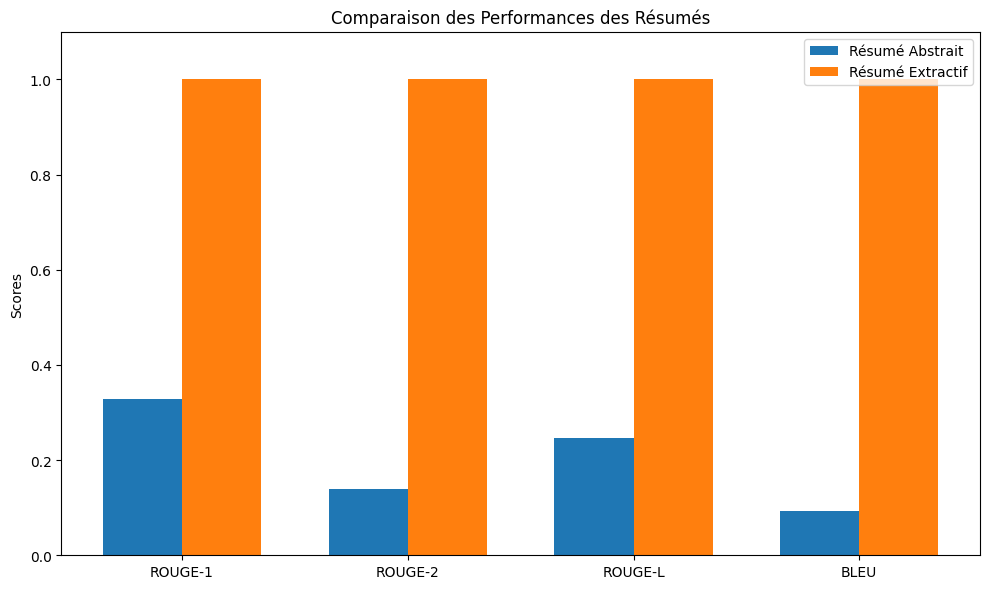

In [20]:
# Données
labels = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'BLEU']
abstract_scores = [0.3278, 0.1401, 0.2474, 0.0921]
extractive_scores = [1.0000, 1.0000, 1.0000, 1.0000]

x = np.arange(len(labels))
width = 0.35

# Création du graphique
plt.figure(figsize=(10, 6))
plt.bar(x - width/2, abstract_scores, width, label='Résumé Abstrait')
plt.bar(x + width/2, extractive_scores, width, label='Résumé Extractif')

# Détails du graphique
plt.ylabel('Scores')
plt.title('Comparaison des Performances des Résumés')
plt.xticks(x, labels)
plt.ylim(0, 1.1)
plt.legend()

# Affichage
plt.tight_layout()
plt.show()

# 4. Évaluation des performances

Génération de résumés :
Générer des résumés à partir du jeu de test pour l’approche abstraite.

Comparaison des approches :

* Évaluer les résumés générés (abstrait et extractif) en utilisant les métriques ROUGE et BLEU.
* Comparer les scores et analyser les résultats.


## 4.1 Génération des résumés: Générér des résumés à partir du jeu de test pour l'approche abstraite.

In [21]:
# Préparer un fichier ou une structure pour stocker les résultats
generated_summaries = []

# Génération des résumés sur le jeu de test
print("Début de la génération des résumés...")
for i in tqdm(range(0, len(ds_split["test"]), 10)):  # Processus par lot
    # Sélectionner un sous-ensemble du jeu de test
    subset = ds_split["test"].select(range(i, min(i + 10, len(ds_split["test"]))))

    # Préparer les entrées pour le modèle
    inputs = tokenizer(
        subset["article"],
        return_tensors="pt",
        max_length=1024,
        truncation=True,
        padding=True
    )

    inputs = {key: value.to(model.device) for key, value in inputs.items()}

    # Générer les prédictions
    with torch.no_grad():
        outputs = model.generate(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            max_length=128, 
            min_length=30,  
            num_beams=4,  
            early_stopping=True
        )

    # Décoder les prédictions
    decoded_predictions = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    generated_summaries.extend(decoded_predictions)

# Afficher quelques exemples de résumés générés
for idx, summary in enumerate(generated_summaries[:5]):
    print(f"Résumé {idx + 1} : {summary}")
'''
# Optionnel : Sauvegarder les résumés dans un fichier
with open("generated_summaries_test.txt", "w") as f:
    for summary in generated_summaries:
        f.write(summary + "\n")

print("Génération des résumés terminée.")
'''

Début de la génération des résumés...


100%|██████████| 20/20 [02:10<00:00,  6.54s/it]

Résumé 1 : vengers made estimated 4571 million domestically passed 450 million 17 days previous record holder dark knight reached milestone 27 days avengers also passed pirates caribbean dead mans chest become disneys biggest movie ever domestically worldwide
Résumé 2 : channel tunnel highspeed operator eurostar monopoly since 2004 opening deutsche bahn german operators access channel tunnel upsets monopoly held route high speed train operator says company negotiating britain france expand footprint eurostar ceo says company planning launch state art fleet carry passengers netherlands germany switzerland eurotunnel 400 trains day channel tunnel average 52 highspeed rail
Résumé 3 :  lynda williams 44 said former boss dr kermit gosnell taught turn baby cut neck pair scissors gave creeps patients given pain medication work procedures would slapped legs squirmed gosnel 72 charged murdering seven babies philadelphia womens medical society clinic former employees said saw 100 live babies kil

'\n# Optionnel : Sauvegarder les résumés dans un fichier\nwith open("generated_summaries_test.txt", "w") as f:\n    for summary in generated_summaries:\n        f.write(summary + "\n")\n\nprint("Génération des résumés terminée.")\n'

##### 4.2 Évaluer les résumés générés (abstrait et extractif) en utilisant les métriques ROUGE et BLEU.

In [22]:
def evaluate_summaries(predictions, references):
    # Convertir les prédictions en chaînes si elles sont tokenisées ou mal formatées
    predictions = [" ".join(pred) if isinstance(pred, list) else pred for pred in predictions]

    references = [
        " ".join(ref) if isinstance(ref, list) else ref for ref in references
    ]

    rouge_metric = evaluate.load("rouge")
    bleu_metric = evaluate.load("bleu")

    rouge_scores = rouge_metric.compute(predictions=predictions, references=references)

    bleu_scores = bleu_metric.compute(
        predictions=predictions,
        references=[[ref] for ref in references]  
    )

    return {**rouge_scores, **bleu_scores}

##### 4.3 Comparaison des scores

In [23]:
# Obtenir les résumés générés (à partir de votre pipeline ou méthode précédente)
abstract_predictions = generated_summaries  # Résumés abstraits générés
extractive_predictions = [item["highlights"] for item in ds_split["test"]]  # Résumés extractifs

# Références communes (highlights)
references = [item["highlights"] for item in ds_split["test"]]

# Évaluer les résumés abstraits
print("Évaluation des résumés abstraits...")
abstract_scores = evaluate_summaries(abstract_predictions, references)

# Évaluer les résumés extractifs
print("Évaluation des résumés extractifs...")
extractive_scores = evaluate_summaries(extractive_predictions, references)

# Comparaison des scores
print("\n--- Résultats Comparatifs ---")
print("Résumé Abstrait :")
# Si abstract_scores est un tuple dont le premier élément est un dictionnaire
'''
if isinstance(abstract_scores, tuple):
    abstract_scores = abstract_scores[0]  # Extraire le dictionnaire des scores
'''
print(f"ROUGE-1 : {abstract_scores['rouge1']:.4f}, ROUGE-2 : {abstract_scores['rouge2']:.4f}, ROUGE-L : {abstract_scores['rougeL']:.4f}")
print(f"BLEU : {abstract_scores['bleu']:.4f}")

print("\nRésumé Extractif :")
print(f"ROUGE-1 : {extractive_scores['rouge1']:.4f}, ROUGE-2 : {extractive_scores['rouge2']:.4f}, ROUGE-L : {extractive_scores['rougeL']:.4f}")
print(f"BLEU : {extractive_scores['bleu']:.4f}")


Évaluation des résumés abstraits...


Évaluation des résumés extractifs...

--- Résultats Comparatifs ---
Résumé Abstrait :
ROUGE-1 : 0.3236, ROUGE-2 : 0.1344, ROUGE-L : 0.2400
BLEU : 0.0898

Résumé Extractif :
ROUGE-1 : 1.0000, ROUGE-2 : 1.0000, ROUGE-L : 1.0000
BLEU : 1.0000


5.   Expérimentation additionnelles (option):
*   Testez le modèle avec des textes d'autres sources pour voir comment il s'adapte à des données nouvelles.
*   Comparez les performances avec différents modèles pré-entraînés ou différentes configurations de l'architecture (par ex. différentes tailles d'encoder/decoder).






